# Triple Negative Breast Cancer(TNBC) Cell Semantic Segmentation

This notebook applies [U-Net](https://arxiv.org/abs/1505.04597) Convolutional Neural Network for semantic segmentation of TNBC cell images.

The dataset for the task is downloaded from [here](https://zenodo.org/record/1175282#.Xl_4nZMzZQJ) 

**Flow of the notebook:**
- Apply U-Net to standard dataset 
- Plot network's perfomance 
- Show sample test segmentation results 
- Apply U-Net to dataset "overlayed" with canny edges
- Plot network's perfomance 
- Show sample test segmentation results 
- Compare newtork's performance on both datasets

Let's get started!

In [2]:
! cd Breast-Cancer-Image-Segmentation && ls

Main.ipynb  _config.yml      canny_edge_overlay.m  metrics.py  plots.py
README.md   augmentation.py  img		   model.py    utils.py


In [1]:
! git clone https://github.com/Jonny-W12138/My-Unet-Tumor-Segment.git

Cloning into 'My-Unet-Tumor-Segment'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 310 (delta 18), reused 152 (delta 2), pack-reused 124
Receiving objects: 100% (310/310), 30.38 MiB | 41.98 MiB/s, done.
Resolving deltas: 100% (79/79), done.


# Triple Negative Breast Cancer

*Triple-negative breast cancer (TNBC) accounts for about 10-15%  of all breast cancers. These cancers tend to be more common in women younger than age 40, who are African-American.*

*Triple-negative breast cancer differs from other types of invasive breast cancer in that they grow and spread faster, have limited treatment options, and a worse prognosis (outcome)*.  - **American Cancer Society**

Thus early stage cancer detection is required to provide proper treatment to the patient and reduce the risk of death due to cancer as detection of these cancer cells at later stages lead to more suffering and increases chances of death. Semantic segmentation of cancer cell images can be used to improvise the analysis and diagonsis of Breast Cancer! Below is such an attempt.

# U-Net

U-Net is a State of the Art CNN architecture for Bio-medical image segmentation. *The architecture consists of a contracting path to capture context and a symmetric expanding path that enables precise localization.* It's a Fully Convolutional Network(FCN) therefore it can **work with arbitrary size images!**

<img src="img/U-Net_arch.png">

In [4]:
! cd Breast-Cancer-Image-Segmentation && ls

Main.ipynb  _config.yml      canny_edge_overlay.m  metrics.py  plots.py
README.md   augmentation.py  img		   model.py    utils.py


In [2]:
import os

input_path = "/kaggle/working/My-Unet-Tumor-Segment"
os.chdir(input_path)

In [3]:
# To ensure GPU is enabled on Colab

# %tensorflow_version 1.x
%matplotlib inline
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2024-07-23 14:28:39.506067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 14:28:39.506166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 14:28:39.779780: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found GPU at: /device:GPU:0


## 1- Import required modules

In [5]:
! pwd

/kaggle/working/My-Unet-Tumor-Segment


In [6]:
from model import *
from augmentation import *
from metrics import *
from plots import *
from utils import *

In [ ]:
#!unzip data1.zip- Folder which contains test and train datasets

### 1.1- How to arrange Directories for using ImageDataGenerator.flow_from_directory()?

- train
    * images
        * img
    * label
        * img
- test
    * images
        * img
    * label
        * img
        
**train, test, images, label,img** are all directories, where *img* is the directory containing images/segmentation masks .png images

In [5]:
# Loads and initalises the U-Net network

m=unet()
m.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_9[0][0]  

 Total params: 31,031,685 (118.38 MB)

 Trainable params: 31,031,685 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

## 2- Model training on Standard Dataset

In [7]:
opt = Adam(learning_rate =1E-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
m.compile(loss=dice_coef_loss, optimizer=opt, metrics=['accuracy', iou, F1, recall, precision]) # Keeping track of these metrics

### 2.1- Why Data Augmentation?

Our training set has **only 33 images** which is nothing when compared to modern day datasets like [ImageNet](http://www.image-net.org/) which has over 1M annotated examples. *But this is generally the case in Bio-medical tasks.* Thus I've used Data Augmentation extensively to increase the dataset.

### 2.2- Why I haven't used ImageNet for Transfer Learning?

You might be wondering why haven't I done "transfer learning" from ImageNet or any similar datasets? Afterall such pre-training is a standard for Deep Learning. 

ImageNet is a "natural image" dataset and I'm here tacking a very specific problem which has images very different from natural images. Thus such pre-training would provide *little* benefit to the performance. For detailed insight into this check [this](https://arxiv.org/abs/1902.07208) wonderful paper which digs deep into Transfer learning for Medical tasks.

In [8]:
! ls /kaggle/working/Breast-Cancer-Image-Segmentation/train/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


images	label


In [7]:
# 弃用
checkpoint = ModelCheckpoint('unet_weights.keras', monitor='loss', 
                             verbose=1, save_best_only=True, mode='min') # Checkpoint to store "only" the best weights during training
                                                                         # Weights will be saved in file named 'unet_weights.hdf5'
train_generator=train_data_aug() # Peforms real-time Data Augmentation on the Training dataset. See augmentation.py for more details
results = m.fit(train_generator, epochs=50, steps_per_epoch=16, callbacks=[checkpoint])

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


ValueError: Unrecognized data type: x=<zip object at 0x7ef678295840> (of type <class 'zip'>)

In [24]:
! mv /kaggle/working/Breast-Cancer-Image-Segmentation/tbnc-tests/* /kaggle/working/Breast-Cancer-Image-Segmentation/

In [25]:
# 跳过
def train_data_aug_v2(canny=False):
    """Performs real-time Data Augmentation on the Training dataset used in 'model.fit()'

    Args:
        canny (bool): If True performs augmentation on 'train_canny' directory else on 'train' directory

    Returns:
        generator: Custom generator that yields image and mask pairs after augmentation
    """
    seed = 1  # To ensure correct mapping of train images to corresponding mask

    # Define what augmentation should take place
    image_datagen = ImageDataGenerator(rotation_range=0.2, rescale=1./255, width_shift_range=0.05, 
                                       height_shift_range=0.05, shear_range=0.05, zoom_range=0.05,
                                       horizontal_flip=True, fill_mode='nearest') 
    mask_datagen = ImageDataGenerator(rotation_range=0.2, rescale=1./255, width_shift_range=0.05,
                                      height_shift_range=0.05, shear_range=0.05, zoom_range=0.05,
                                      horizontal_flip=True, fill_mode='nearest')  
    
    # Directory containing train image dataset
    dir = '/kaggle/working/Breast-Cancer-Image-Segmentation/train/'  
    if canny:
        dir = '/kaggle/working/Breast-Cancer-Image-Segmentation/train_canny/'  # Directory containing train images overlaid with their "Canny edges"

    print(dir)
    
    # Create image and mask generators
    image_generator = image_datagen.flow_from_directory(
        dir,
        classes=['images'],
        class_mode=None,
        seed=seed,
        color_mode="grayscale",
        target_size=(256, 256),
        batch_size=2
    )
    
    mask_generator = mask_datagen.flow_from_directory(
        dir,
        classes=['label'],
        class_mode=None,
        seed=seed,
        color_mode="grayscale",
        target_size=(256, 256),
        batch_size=2
    )

    # Custom generator to yield image and mask pairs
    def custom_generator(image_gen, mask_gen):
        while True:
            image_batch = next(image_gen)
            mask_batch = next(mask_gen)
            yield (image_batch, mask_batch)

    train_generator = custom_generator(image_generator, mask_generator)
    return train_generator

In [26]:
# 跳过
from keras.metrics import MeanIoU, Precision, Recall

# 定义优化器
opt = Adam(learning_rate=1E-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# 添加自定义指标到模型中
m.compile(optimizer=opt, 
          loss='binary_crossentropy', 
          metrics=['accuracy', MeanIoU(num_classes=2), Precision(), Recall()])

# 定义 ModelCheckpoint 回调
checkpoint = ModelCheckpoint('unet_weights.keras', monitor='loss', 
                             verbose=1, save_best_only=True, mode='min')

# 获取训练数据生成器
train_generator = train_data_aug_v2()

# 使用 fit 方法训练模型
results = m.fit(train_generator, epochs=10, steps_per_epoch=16, callbacks=[checkpoint])

/kaggle/working/Breast-Cancer-Image-Segmentation/train/
Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Epoch 1/10
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u_5: 0.0000e+00 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 

I0000 00:00:1721743290.241133     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: loss improved from inf to 0.00000, saving model to unet_weights.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u_5: 0.0000e+00 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 2/10
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u_5: 0.0000e+00 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 2: loss did not improve from 0.00000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u_5: 0.0000e+00 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 3/10
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u_5: 0.0000e+00 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 3: loss did not improve from 0.00000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u_5: 0.0000e+00 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 4/10
13/16 ━━━━━━━━━━

In [15]:
def train_data_aug_v3(canny=False):
    """Performs real-time Data Augmentation on the Training dataset used in 'model.fit()'

    Args:
        canny (bool): If True performs augmentation on 'train_canny' directory else on 'train' directory

    Returns:
        generator: Custom generator that yields image and mask pairs after augmentation
    """
    seed = 1  # To ensure correct mapping of train images to corresponding mask

    # Define what augmentation should take place
    image_datagen = ImageDataGenerator(rotation_range=0.2, rescale=1./255, width_shift_range=0.05, 
                                       height_shift_range=0.05, shear_range=0.05, zoom_range=0.05,
                                       horizontal_flip=True, fill_mode='nearest') 
    mask_datagen = ImageDataGenerator(rotation_range=0.2, rescale=1./255, width_shift_range=0.05,
                                      height_shift_range=0.05, shear_range=0.05, zoom_range=0.05,
                                      horizontal_flip=True, fill_mode='nearest')  
    
    # Directory containing train image dataset
    dir = '/kaggle/working/My-Unet-Tumor-Segment/train/'  
    if canny:
        dir = '/kaggle/working/My-Unet-Tumor-Segment/train_canny/'  # Directory containing train images overlaid with their "Canny edges"

    # Create generators
    image_generator = image_datagen.flow_from_directory(
        dir,
        classes=['images'],
        class_mode=None,
        color_mode='grayscale',
        target_size=(256, 256),
        batch_size=1,
        seed=seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        dir,
        classes=['masks'],
        class_mode=None,
        color_mode='grayscale',
        target_size=(256, 256),
        batch_size=1,
        seed=seed)
    
    # Combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)
    return train_generator

In [24]:
from keras.metrics import MeanIoU, Precision, Recall

def train_data_aug_v4(canny=False):
    """Performs real-time Data Augmentation on the Training dataset used in 'model.fit()'

    Args:
        canny (bool): If True performs augmentation on 'train_canny' directory else on 'train' directory

    Returns:
        generator: Custom generator that yields image and mask pairs after augmentation
    """
    seed = 1  # To ensure correct mapping of train images to corresponding mask

    # Define what augmentation should take place
    image_datagen = ImageDataGenerator(rotation_range=0.2, rescale=1./255, width_shift_range=0.05, 
                                       height_shift_range=0.05, shear_range=0.05, zoom_range=0.05,
                                       horizontal_flip=True, fill_mode='nearest') 
    mask_datagen = ImageDataGenerator(rotation_range=0.2, rescale=1./255, width_shift_range=0.05,
                                      height_shift_range=0.05, shear_range=0.05, zoom_range=0.05,
                                      horizontal_flip=True, fill_mode='nearest')  
    
    # Directory containing train image dataset
    dir = '/kaggle/working/My-Unet-Tumor-Segment/train/'  
    if canny:
        dir = '/kaggle/working/My-Unet-Tumor-Segment/train_canny/'  # Directory containing train images overlaid with their "Canny edges"

    # Create generators
    image_generator = image_datagen.flow_from_directory(
        dir,
        classes=['images'],
        class_mode=None,
        color_mode='grayscale',
        target_size=(256, 256),
        batch_size=1,
        seed=seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        dir,
        classes=['masks'],
        class_mode=None,
        color_mode='grayscale',
        target_size=(256, 256),
        batch_size=1,
        seed=seed)

    # Combine generators into one which yields image and masks
    def generator():
        while True:
            image_batch = next(image_generator)
            mask_batch = next(mask_generator)
            yield (image_batch, mask_batch)

    return generator()

# 定义自定义指标
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def f1_score(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    tp = tf.keras.backend.sum(y_true_f * y_pred_f)
    fp = tf.keras.backend.sum((1 - y_true_f) * y_pred_f)
    fn = tf.keras.backend.sum(y_true_f * (1 - y_pred_f))
    return tp / (tp + 0.5 * (fp + fn) + tf.keras.backend.epsilon())

# 定义优化器
opt = Adam(learning_rate=1E-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# 添加自定义指标到模型中
m.compile(optimizer=opt, 
          loss='binary_crossentropy', 
          metrics=['accuracy', MeanIoU(num_classes=2), Precision(), Recall(), dice_loss, f1_score])

# 定义 ModelCheckpoint 回调
checkpoint = ModelCheckpoint('unet_weights.keras', monitor='loss', 
                             verbose=1, save_best_only=True, mode='min')

# 获取训练数据生成器
train_generator = train_data_aug_v4()

# 使用 fit 方法训练模型
results = m.fit(train_generator, epochs=10, steps_per_epoch=16, callbacks=[checkpoint])


Found 33 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node stack defined at (most recent call last):
<stack traces unavailable>
Shapes of all inputs must match: values[0].shape = [0] != values[1].shape = [65536]

Stack trace for op definition: 
File "opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
File "opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
File "opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
File "opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start
File "opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
File "opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
File "opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue
File "opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one
File "opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell
File "opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request
File "opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute
File "opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
File "opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell
File "opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell
File "opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
File "opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async
File "opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes
File "opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "tmp/ipykernel_34/3318581070.py", line 87, in <module>
File "opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit
File "opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator
File "opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data
File "opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 77, in train_step
File "opt/conda/lib/python3.10/site-packages/keras/src/trainers/trainer.py", line 444, in compute_metrics
File "opt/conda/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 330, in update_state
File "opt/conda/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 17, in update_state
File "opt/conda/lib/python3.10/site-packages/keras/src/metrics/iou_metrics.py", line 129, in update_state
File "opt/conda/lib/python3.10/site-packages/keras/src/metrics/metrics_utils.py", line 677, in confusion_matrix
File "opt/conda/lib/python3.10/site-packages/keras/src/ops/numpy.py", line 4757, in stack
File "opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/numpy.py", line 1872, in stack

	 [[{{node stack}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_10107[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_10444]

In [16]:
from keras.metrics import MeanIoU, Precision, Recall

# 定义自定义指标
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def f1_score(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    tp = tf.keras.backend.sum(y_true_f * y_pred_f)
    fp = tf.keras.backend.sum((1 - y_true_f) * y_pred_f)
    fn = tf.keras.backend.sum(y_true_f * (1 - y_pred_f))
    return tp / (tp + 0.5 * (fp + fn) + tf.keras.backend.epsilon())

# 定义优化器
opt = Adam(learning_rate=1E-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# 添加自定义指标到模型中
m.compile(optimizer=opt, 
          loss='binary_crossentropy', 
          metrics=['accuracy', MeanIoU(num_classes=2), Precision(), Recall(), dice_loss, f1_score])

# 定义 ModelCheckpoint 回调
checkpoint = ModelCheckpoint('unet_weights.keras', monitor='loss', 
                             verbose=1, save_best_only=True, mode='min')

# 获取训练数据生成器
train_generator = train_data_aug_v3()

# 使用 fit 方法训练模型
results = m.fit(train_generator, epochs=10, steps_per_epoch=16, callbacks=[checkpoint])

Found 33 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


ValueError: Unrecognized data type: x=<zip object at 0x7a37f4a6ff00> (of type <class 'zip'>)

In [30]:
def train_data_aug_v5(canny=False):
    """Performs real-time Data Augmentation on the Training dataset used in 'model.fit()'

    Args:
        canny (bool): If True performs augmentation on 'train_canny' directory else on 'train' directory

    Returns:
        generator: Custom generator that yields image and mask pairs after augmentation
    """
    seed = 1  # To ensure correct mapping of train images to corresponding mask

    # Define what augmentation should take place
    image_datagen = ImageDataGenerator(rotation_range=0.2, rescale=1./255, width_shift_range=0.05, 
                                       height_shift_range=0.05, shear_range=0.05, zoom_range=0.05,
                                       horizontal_flip=True, fill_mode='nearest') 
    mask_datagen = ImageDataGenerator(rotation_range=0.2, rescale=1./255, width_shift_range=0.05,
                                      height_shift_range=0.05, shear_range=0.05, zoom_range=0.05,
                                      horizontal_flip=True, fill_mode='nearest')  
    
    # Directory containing train image dataset
    dir = '/kaggle/working/Breast-Cancer-Image-Segmentation/train/'  
    if canny:
        dir = '/kaggle/working/Breast-Cancer-Image-Segmentation/train_canny/'  # Directory containing train images overlaid with their "Canny edges"

    print(dir)
    
    # Create image and mask generators
    image_generator = image_datagen.flow_from_directory(
        dir,
        classes=['images'],
        class_mode=None,
        seed=seed,
        color_mode="grayscale",
        target_size=(256, 256),
        batch_size=2
    )
    
    mask_generator = mask_datagen.flow_from_directory(
        dir,
        classes=['label'],
        class_mode=None,
        seed=seed,
        color_mode="grayscale",
        target_size=(256, 256),
        batch_size=2
    )

    # Custom generator to yield image and mask pairs
    def custom_generator(image_gen, mask_gen):
        while True:
            image_batch = next(image_gen)
            mask_batch = next(mask_gen)
            yield (image_batch, mask_batch)

    train_generator = custom_generator(image_generator, mask_generator)
    return train_generator

In [31]:
from keras.metrics import MeanIoU, Precision, Recall

# 定义优化器
opt = Adam(learning_rate=1E-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# 添加自定义指标到模型中
m.compile(optimizer=opt, 
          loss='binary_crossentropy', 
          metrics=['accuracy', MeanIoU(num_classes=2), Precision(), Recall()])

# 定义 ModelCheckpoint 回调
checkpoint = ModelCheckpoint('unet_weights.keras', monitor='loss', 
                             verbose=1, save_best_only=True, mode='min')

# 获取训练数据生成器
train_generator = train_data_aug_v5()

# 使用 fit 方法训练模型
results = m.fit(train_generator, epochs=10, steps_per_epoch=16, callbacks=[checkpoint])

/kaggle/working/Breast-Cancer-Image-Segmentation/train/
Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Epoch 1/10
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u_6: 0.0000e+00 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 1: loss improved from inf to 0.00000, saving model to unet_weights.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u_6: 0.0000e+00 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 2/10
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u_6: 0.0000e+00 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 2: loss did not improve from 0.00000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u_6: 0.0000e+00 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 3/10
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - 

In [8]:
def train_data_aug_v2(canny=False):
    """Performs real-time Data Augmentation on the Training dataset used in 'model.fit()'

    Args:
        canny (bool): If True performs augmentation on 'train_canny' directory else on 'train' directory

    Returns:
        generator: Custom generator that yields image and mask pairs after augmentation
    """
    seed = 1  # To ensure correct mapping of train images to corresponding mask

    # Define what augmentation should take place
    image_datagen = ImageDataGenerator(rotation_range=0.2, rescale=1./255, width_shift_range=0.05, 
                                       height_shift_range=0.05, shear_range=0.05, zoom_range=0.05,
                                       horizontal_flip=True, fill_mode='nearest') 
    mask_datagen = ImageDataGenerator(rotation_range=0.2, rescale=1./255, width_shift_range=0.05,
                                      height_shift_range=0.05, shear_range=0.05, zoom_range=0.05,
                                      horizontal_flip=True, fill_mode='nearest')  
    
    # Directory containing train image dataset
    dir = '/kaggle/working/My-Unet-Tumor-Segment/train/'  
    if canny:
        dir = '/kaggle/working/My-Unet-Tumor-Segment/train_canny/'  # Directory containing train images overlaid with their "Canny edges"

    print(dir)
    
    # Create image and mask generators
    image_generator = image_datagen.flow_from_directory(
        dir,
        classes=['images'],
        class_mode=None,
        seed=seed,
        color_mode="grayscale",
        target_size=(256, 256),
        batch_size=2
    )
    
    mask_generator = mask_datagen.flow_from_directory(
        dir,
        classes=['label'],
        class_mode=None,
        seed=seed,
        color_mode="grayscale",
        target_size=(256, 256),
        batch_size=2
    )

    # Custom generator to yield image and mask pairs
    def custom_generator(image_gen, mask_gen):
        while True:
            image_batch = next(image_gen)
            mask_batch = next(mask_gen)
            yield (image_batch, mask_batch)

    train_generator = custom_generator(image_generator, mask_generator)
    return train_generator

In [9]:
from keras.optimizers import Adam

opt = Adam(learning_rate =1E-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
m.compile(loss=dice_coef_loss, optimizer=opt, metrics=['accuracy', iou, F1, recall, precision]) # Keeping track of these metrics

In [10]:
from keras.metrics import MeanIoU, Precision, Recall

# 定义优化器
opt = Adam(learning_rate=1E-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# 添加自定义指标到模型中
m.compile(optimizer=opt, 
          loss='binary_crossentropy', 
          metrics=['accuracy', MeanIoU(num_classes=2), Precision(), Recall()])

# 定义 ModelCheckpoint 回调
checkpoint = ModelCheckpoint('unet_weights.keras', monitor='loss', 
                             verbose=1, save_best_only=True, mode='min')

# 获取训练数据生成器
train_generator = train_data_aug_v2()

# 使用 fit 方法训练模型
results = m.fit(train_generator, epochs=10, steps_per_epoch=16, callbacks=[checkpoint])

/kaggle/working/My-Unet-Tumor-Segment/train/
Found 33 images belonging to 1 classes.
Found 33 images belonging to 1 classes.
Epoch 1/10


I0000 00:00:1721745033.436756     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8543 - loss: 0.4228 - mean_io_u: 0.4585 - precision: 0.1288 - recall: 0.0160
Epoch 1: loss improved from inf to 0.41100, saving model to unet_weights.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 65s 352ms/step - accuracy: 0.8535 - loss: 0.4221 - mean_io_u: 0.4581 - precision: 0.1293 - recall: 0.0156
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8751 - loss: 0.3309 - mean_io_u: 0.4625 - precision: 0.0863 - recall: 0.0044
Epoch 2: loss improved from 0.41100 to 0.37742, saving model to unet_weights.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 287ms/step - accuracy: 0.8734 - loss: 0.3337 - mean_io_u: 0.4619 - precision: 0.0868 - recall: 0.0044
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8961 - loss: 0.2881 - mean_io_u: 0.4692 - precision: 0.0803 - recall: 0.0048
Epoch 3: loss improved from 0.37742 to 0.32551, saving model to unet_weights.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.8947 - loss: 0.2

In [ ]:
# 绘制训练曲线
training_history_plot(results)

## 3- Plotting model's training history

### 3.1- Why is the Learning Curve such?

I've trained the model before many times and in previous trainings the "Learning Curve" was exactly as a good learning curve should be ie. noisyier but "trending" downward for Loss function.

In [11]:
print(results.history.keys())

dict_keys(['accuracy', 'loss', 'mean_io_u', 'precision', 'recall'])


KeyError: 'dice_loss'

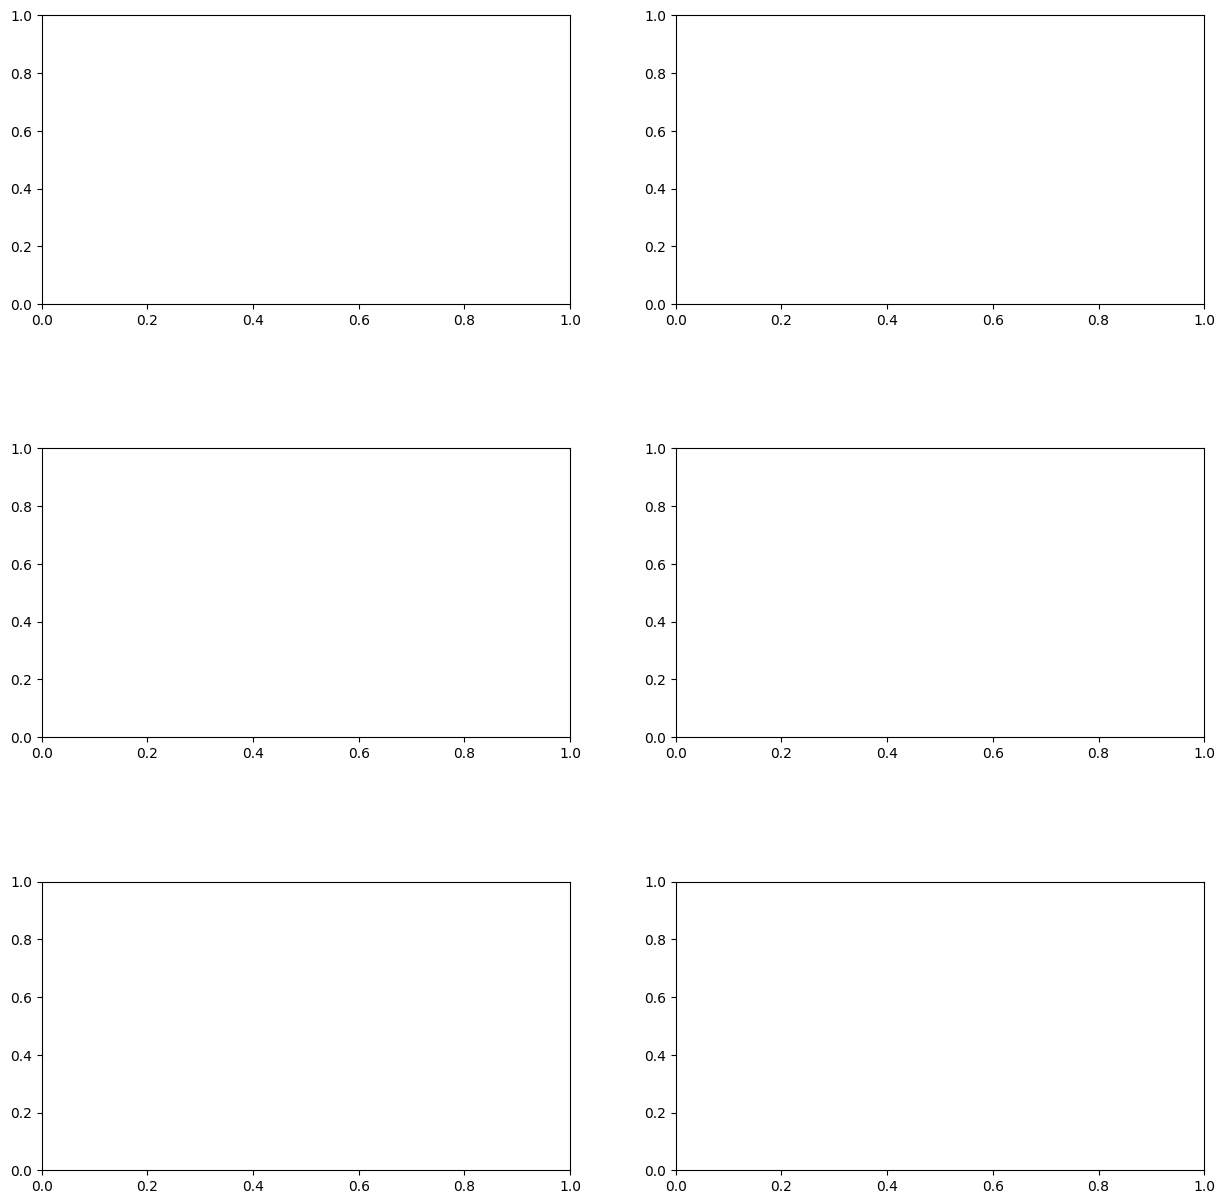

In [12]:
from plots import *

training_history_plot(results) # Plots "training curve" for the network/model for metrics listed above. See plots.py for more details

## 4- Model's Performance on various Metrics

In [13]:
titles = ['Dice Loss','Accuracy','IOU','F1','Recall','Precision']
test_generator=test_data_aug() # Peforms real-time Data Augmentation(here only re-scaling and converting to grayscale) on the Test/Validation dataset. See augmentation.py for more details
performance=m.evaluate_generator(test_generator, verbose=1,steps=17)

for i in range(6):
  print("%s = %f" %(titles[i], performance[i]))

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


AttributeError: 'Functional' object has no attribute 'evaluate_generator'

In [ ]:
#!unzip test2.zip- Folder which contains the dataset for Test performance evaluation

### 4.1- Structure of test2 directory

- test2
    * 0
        * 0
            * 0.png
    * 1
        * 1
            * 1.png
            
Such weird file structure is because there should be **"two" nested directories** in the container directory(test2)

In [17]:
! cp -r /kaggle/input/tnbc-test2/* /kaggle/working/Breast-Cancer-Image-Segmentation/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [14]:
results=np.zeros(shape=(17,256,256,1))
for i in range(17): # As we have 17 test images 
  results[i,:,:,:]=predict(i, m) # Predicts the segmentation labels on images in test2 directory. See utils.py for more details

Found 1 images belonging to 1 classes.


AttributeError: 'Functional' object has no attribute 'predict_generator'

In [11]:
from tensorflow.keras.preprocessing import image

def load_image(image_path, target_size=(256, 256)):
    """Loads and preprocesses an image."""
    img = image.load_img(image_path, target_size=target_size, color_mode="grayscale")
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

def mypredict(index, model):
    """Predicts segmentation labels for the image at the given index."""
    img_path = f"test2/{index}/{index}/{index}.png"
    img = load_image(img_path)
    prediction = model.predict(img, verbose=1)
    return prediction

# 假设你已经定义了模型 m 并加载了训练好的权重
# m = ... (定义和加载模型)

# 预测并保存结果
results = np.zeros(shape=(17, 256, 256, 1))
for i in range(17):  # 假设我们有 17 张测试图片
    results[i, :, :, :] = mypredict(i, m)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


## 5- Sample Results

Starting from the left:
    - First image is original test image "converted" to grayscale
    - Second is the predicted segmentation labels for above image
    - Third one is a Binary mask ie. pixel values of only 0's and 1's, obtained by thresholding on Predicted segmentation, below is for threshold value 0.2, implies all pixel values greater than 0.2 in Predicted segmentation get 1 and others get 0
    - Rightmost is the Ground Truth segmentation label for this test image
    
Below we see that segmentation results are very good considering the fact that we had only 33 images our training dataset which is very limited! 

In [29]:
! cp -r /kaggle/input/tbnc-test/test /kaggle/working/Breast-Cancer-Image-Segmentation/

FileNotFoundError: [Errno 2] No such file or directory: 'test/images/img/2.png'

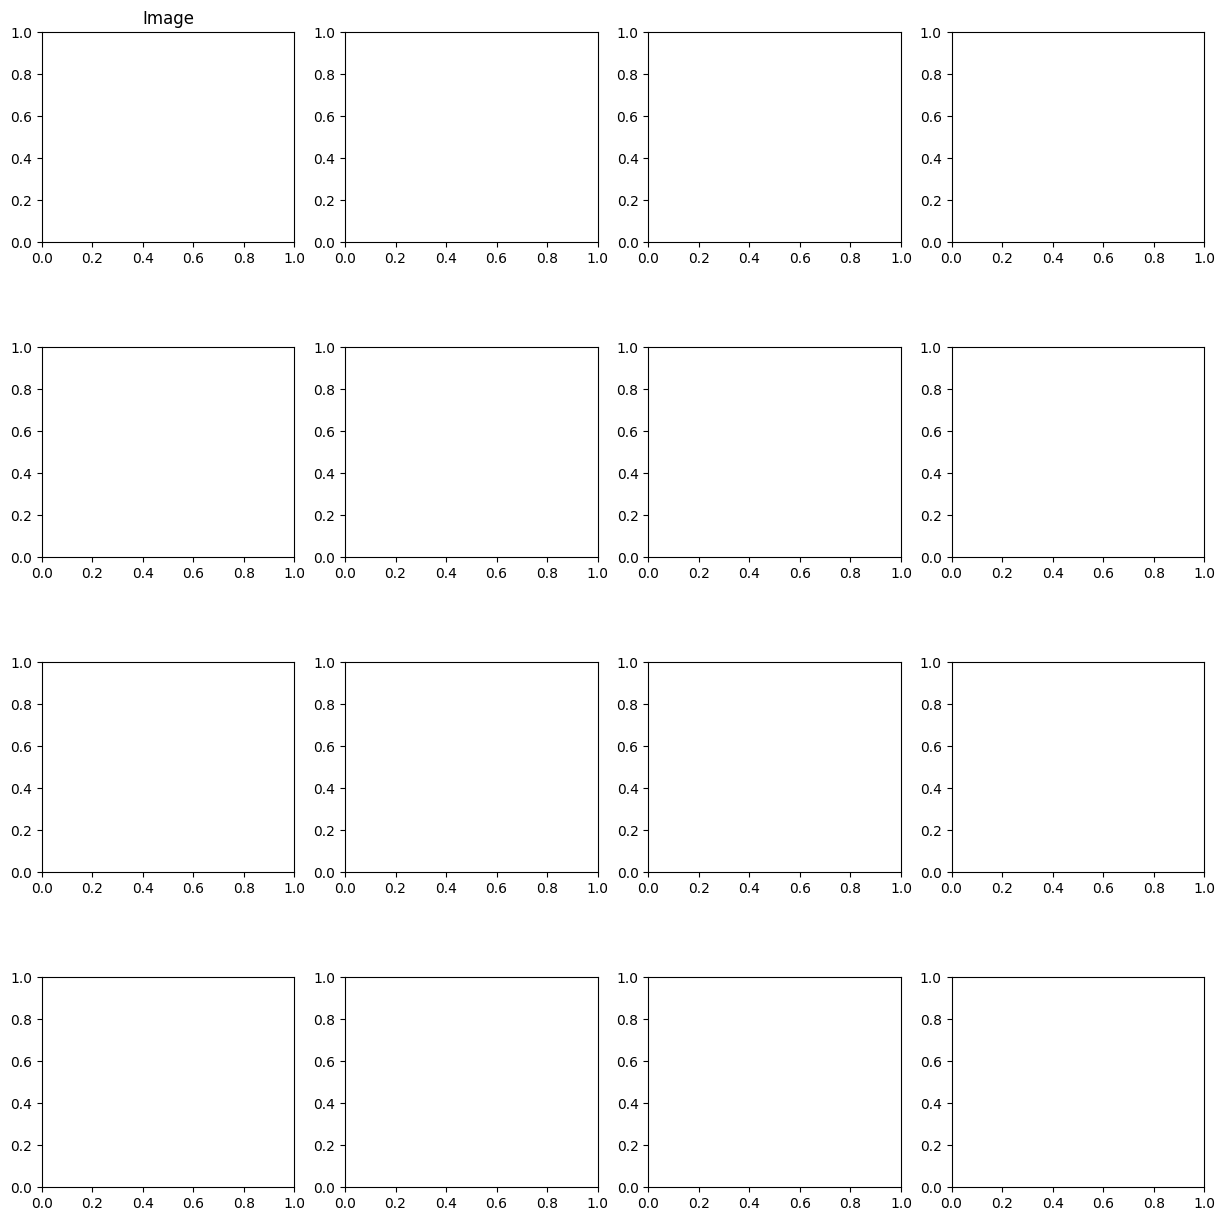

In [12]:
model_prediction_plot(results, t=0.2) # See plots.py for more details

## 6- Model training on Canny Dataset

In [29]:
# Loads and initalises another U-Net network. This will be trained on dataset "overlayed" with their corresponding Canny Edges

m_c=unet()
m_c.summary()

Model: "model_5"

__________________________________________________________________________________________________

Layer (type)                    Output Shape         Param #     Connected to                     


input_5 (InputLayer)            (None, 256, 256, 1)  0                                            

__________________________________________________________________________________________________

conv2d_97 (Conv2D)              (None, 256, 256, 64) 640         input_5[0][0]                    

__________________________________________________________________________________________________

conv2d_98 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_97[0][0]                  

__________________________________________________________________________________________________

max_pooling2d_17 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_98[0][0]                  

_________________________________________________________________________________

/content/model.py:69: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`

  model = Model(input = inputs, output = conv10)


In [ ]:
#!unzip canny.zip - Folder which contains test and train datasets overlayed with Canny Edges

In [ ]:
opt_c = Adam(lr=1E-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
m_c.compile(loss=dice_coef_loss, optimizer=opt_c, metrics=['accuracy', iou, F1, recall, precision])

In [55]:
checkpoint_c = ModelCheckpoint('unet_canny_weights.hdf5', monitor='loss', 
                             verbose=1, save_best_only=True, mode='min') # Different checkpoint for storing "only" best wieghts during training
                                                                         # Weights will be saved in file named 'unet_canny_weights.hdf5'
train_generator_c=train_data_aug(True) # Peforms real-time Data Augmentation on the Canny Training dataset. See augmentation.py for more details
results_c = m_c.fit_generator(train_generator_c, epochs=100, steps_per_epoch = 8, callbacks=[checkpoint_c])

Found 33 images belonging to 1 classes.

Found 33 images belonging to 1 classes.

Epoch 1/100

8/8 [==============================] - 4s 558ms/step - loss: 0.0277 - acc: 0.9025 - iou: 0.2375 - F1: 0.3804 - recall: 0.4536 - precision: 0.6941



Epoch 00001: loss improved from inf to 0.02770, saving model to unet_canny_weights.hdf5

Epoch 2/100

8/8 [==============================] - 1s 106ms/step - loss: 0.0306 - acc: 0.8856 - iou: 0.2603 - F1: 0.4088 - recall: 0.5022 - precision: 0.6694



Epoch 00002: loss did not improve from 0.02770

Epoch 3/100

8/8 [==============================] - 1s 97ms/step - loss: 0.0361 - acc: 0.8698 - iou: 0.2527 - F1: 0.4002 - recall: 0.3802 - precision: 0.7324



Epoch 00003: loss did not improve from 0.02770

Epoch 4/100

8/8 [==============================] - 1s 102ms/step - loss: 0.0233 - acc: 0.9093 - iou: 0.2539 - F1: 0.4013 - recall: 0.4341 - precision: 0.7124



Epoch 00004: loss improved from 0.02770 to 0.02332, saving model to unet_canny_weights

## 7- Plotting model's training history on Canny dataset

### 7.1- Why is the Learning Curve such?

I've trained the model before many times and in previous trainings the "Learning Curve" was exactly as a good learning curve should be ie. noisier but "trending" downwards for the Loss function.

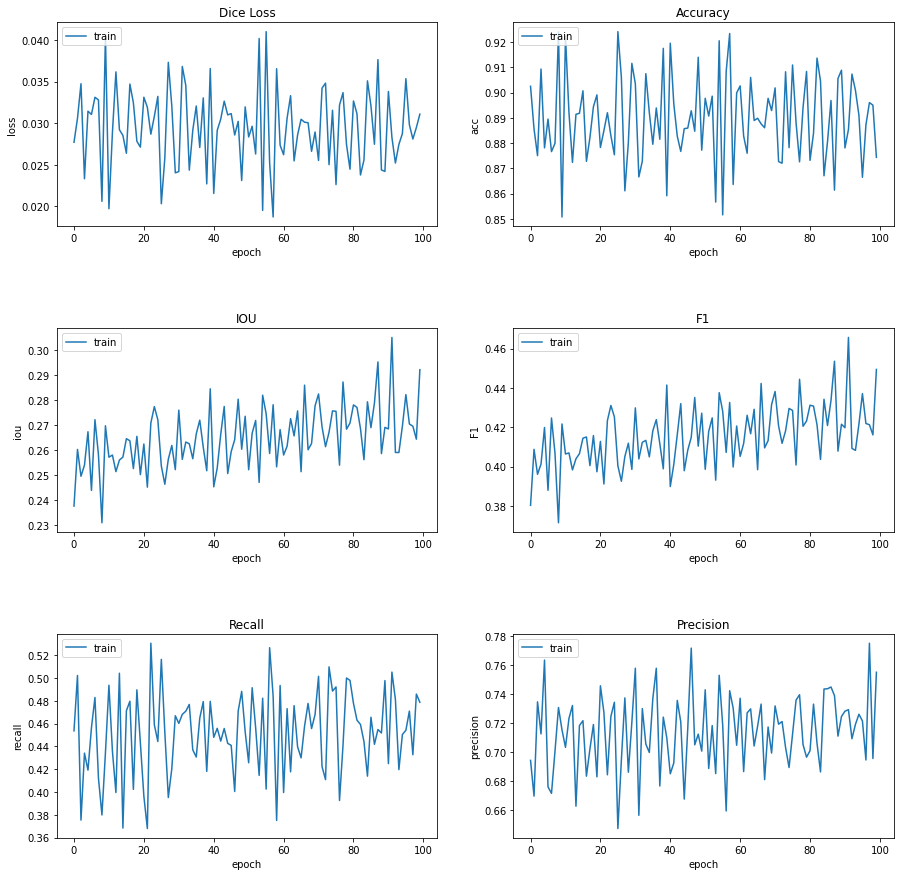

In [56]:
training_history_plot(results_c)

## 8- Model's Performance on various Metrics trained on Canny dataset

In [ ]:
#!unzip test.zip

In [57]:
titles = ['Dice Loss','Accuracy','IOU','F1','Recall','Precision']
test_generator_c=test_data_aug(True) # Peforms real-time Data Augmentation(here only re-scaling and converting to grayscale) on the Test/Validation Canny dataset. See augmentation.py for more details
performance_c=m_c.evaluate_generator(test_generator_c, verbose=1,steps=17)

for i in range(6):
  print("%s = %f" %(titles[i], performance_c[i]))

Found 17 images belonging to 1 classes.

Found 17 images belonging to 1 classes.

17/17 [==============================] - 1s 73ms/step

Dice Loss = 0.046289

Accuracy = 0.889649

IOU = 0.238082

F1 = 0.376991

Recall = 0.535058

Precision = 0.611523


In [ ]:
results_c=np.zeros(shape=(17,256,256,1))
# Predicts the segmentation labels on images in test2 directory. Note: Test dataset has also undergone Canny "overlay"
# as our model was trained on Canny "overlayed" images 
for i in range(17):
  results_c[i,:,:,:]=predict(i, m_c) # See utils.py for more details

Found 1 images belonging to 1 classes.

1/1 [==============================] - 0s 409ms/step

Found 1 images belonging to 1 classes.

1/1 [==============================] - 0s 44ms/step

Found 1 images belonging to 1 classes.

1/1 [==============================] - 0s 56ms/step

Found 1 images belonging to 1 classes.

1/1 [==============================] - 0s 48ms/step

Found 1 images belonging to 1 classes.

1/1 [==============================] - 0s 50ms/step

Found 1 images belonging to 1 classes.

1/1 [==============================] - 0s 53ms/step

Found 1 images belonging to 1 classes.

1/1 [==============================] - 0s 50ms/step

Found 1 images belonging to 1 classes.

1/1 [==============================] - 0s 43ms/step

Found 1 images belonging to 1 classes.

1/1 [==============================] - 0s 44ms/step

Found 1 images belonging to 1 classes.

1/1 [==============================] - 0s 48ms/step

Found 1 images belonging to 1 classes.

1/1 [========================

## 9- Activation Map on Canny dataset

Below is the visualisation of Activation Maps of the model trained on Canny dataset. These visuals are the *activations or the output* of given layer and channel of U-Net CNN. These visualisations tell us **What the model has learnt** or more specifically what the convolutional filters have learnt! It also gives a sense of the **other Biological/Medical features** in the image.

Starting from the left:
    - First image is original test image
    - Second is the Activation Map for provided layer and channel
    - Third one is the Transparent "overlay" of the Activation Map over the test image
For more information see plots.py

**Note:** As I'm using **'jet' cmap** so red corresponds to high activation values and blue to low ones, and green/yellow in the middle in the Activation Map.

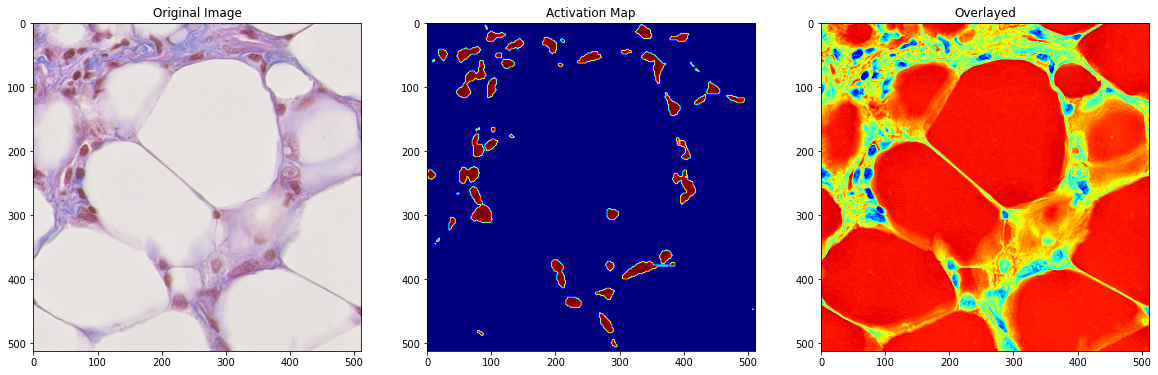

In [58]:
activation_map('9.png',38,0, m_c)

The filter corresponding to the last layer and it's only filter has learnt to **segment Cancer cells**, marked in red in the second image! When overlayed on the original image clearly distinguishes Cancer and non-Cancer cells.

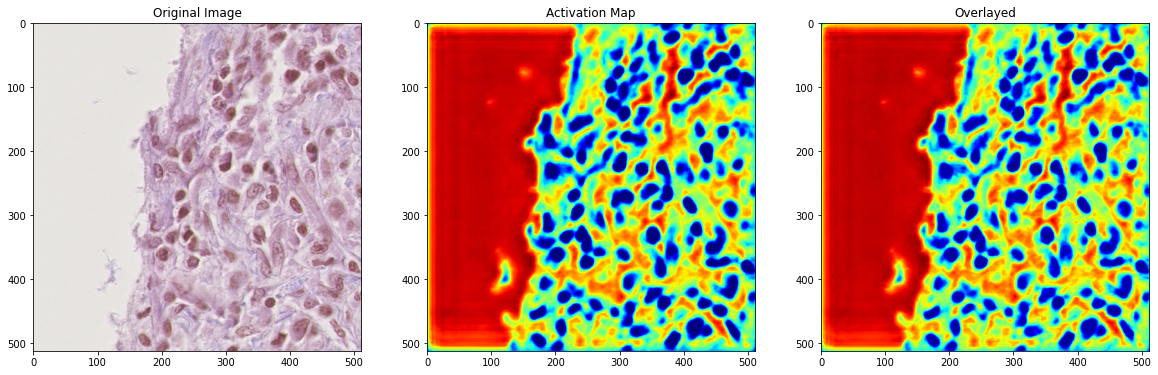

In [85]:
activation_map('22.png',37,0,m_c)

As clearly seen above the corresponding filter has learnt to identify **empty regions** see red region in centre image, remember "Red" corresponds to high activation in Activation Map! Also note that Cancer cells have low activations here, marked in blue so in a way *this filter is ignoring those cells.*

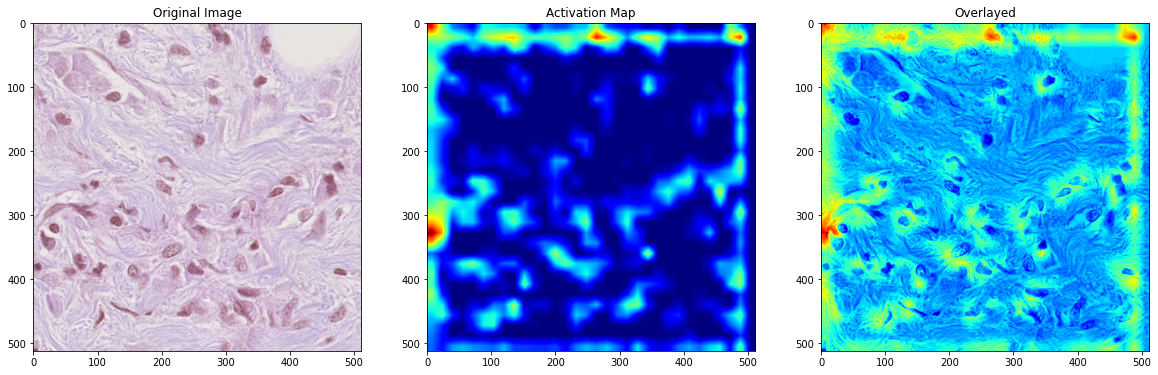

In [99]:
activation_map('15.png',11,298,m_c)

Above is the visual for a middle Conv layer, thus it's neither seeing the entire image as it is nor it's segmentation mask! The "Light Blue" marks in the Activation Map shows that this is *tending to learn to segment Cancer cells.*

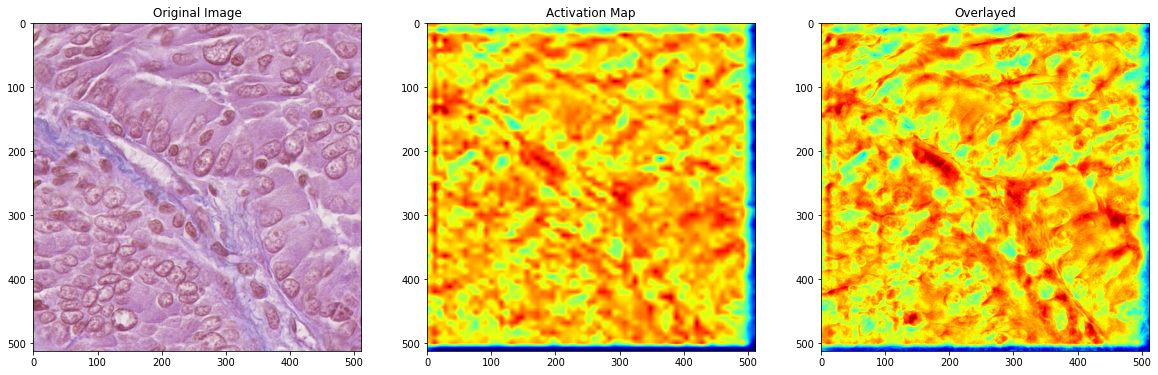

In [74]:
activation_map('0.png',8,0,m_c)

Above visual is for a starting Conv layer it seem to *capture basic features* in the image like edges, gaps between Cancer cells etc. marked in red/yellow.

## 10- Sample Results on Canny Dataset

Starting from the left:
    - First image is original test image "converted" to grayscale
    - Second is the predicted segmentation labels for above image
    - Third one is a Binary mask ie. pixel values of only 0's and 1's, obtained by thresholding on Predicted segmentation, below is for threshold value 0.3, implies all pixel values greater than 0.3 in Predicted segmentation get 1 and others get 0
    - Rightmost is the Ground Truth segmentation label for this test image
    
Below we see that segmentation results are very good considering the fact that we had only 33 images our training dataset which is very limited! 

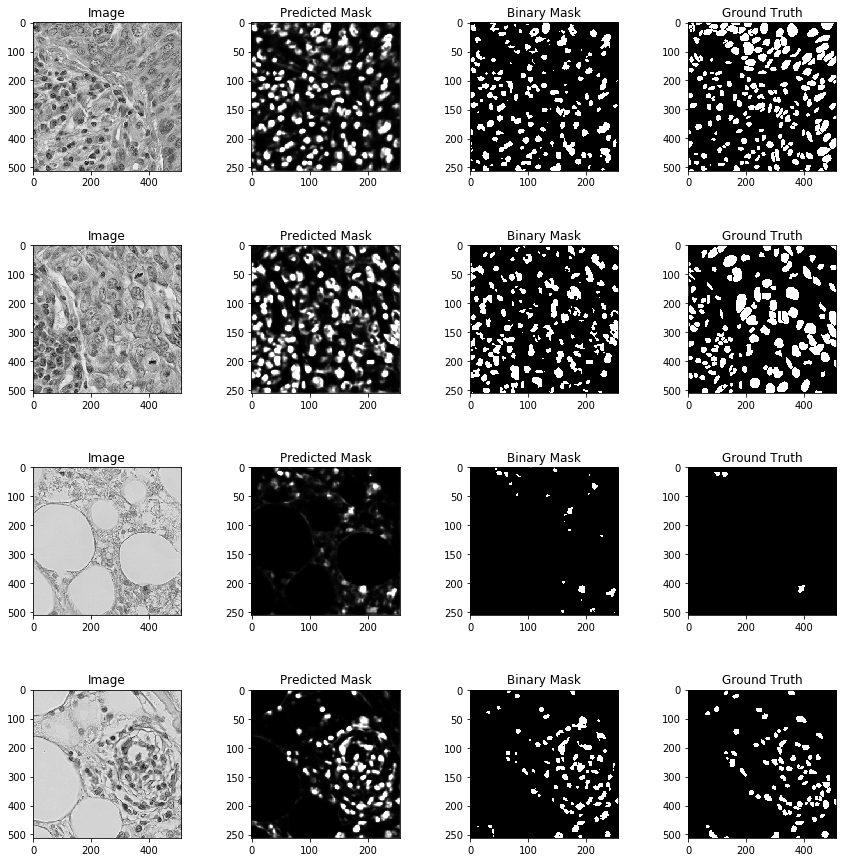

In [ ]:
model_prediction_plot(results_c, 0.3) # See plots.py for more details

## 11- Comparing model's prediction for both Dataset training

Starting from the left:
    - First image is original test image "converted" to grayscale
    - Second is the predicted segmentation labels for above image using model trained on Standard Dataset
    - Third one is the predicted segmentation labels for above image using model trained on Canny "overlayed" Dataset
    - Fourth is a Binary mask ie. pixel values of only 0's and 1's, obtained by thresholding on Predicted segmentation(from Standard dataset), below is for threshold value 0.1(see plots.py), implies all pixel values greater than 0.1 in Predicted segmentation get 1 and others get 0
    - Fifth one is a Binary mask ie. pixel values of only 0's and 1's, obtained by thresholding on Predicted segmentation(from Canny "overlayed" dataset), below is for threshold value 0.2(see plots.py), implies all pixel values greater than 0.2 in Predicted segmentation get 1 and others get 0
    - Rightmost is the Ground Truth segmentation label for this test image
    
***Below we see that segmentation results from model trained on Canny dataset is better than the one trained on the Standard Dataset!***

**Note:** The text labels for 3rd and 4th images below are swapped, the correct order is as listed above

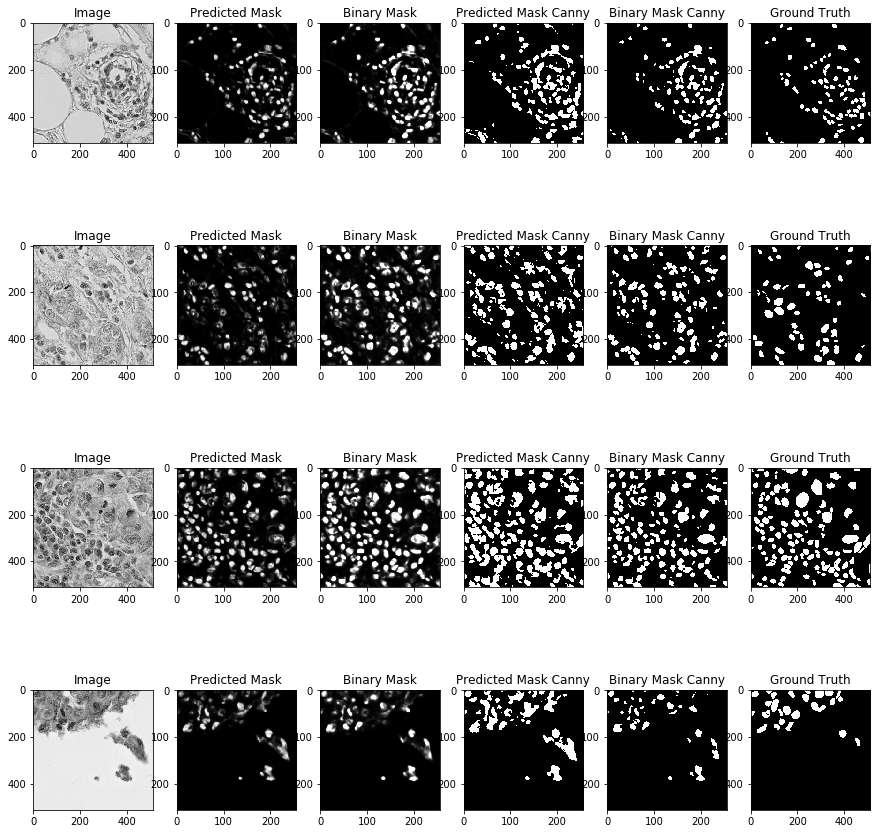

In [ ]:
canny_compare_plot(results, results_c) # Compares model's performance on the "standard" dataset and dataset "overlayed" with "canny edges"

## 12- References

1. [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)
2. [Triple Negative Breast Cancer- American Cancer Society](https://www.cancer.org/cancer/breast-cancer/understanding-a-breast-cancer-diagnosis/types-of-breast-cancer/triple-negative.html)
3. [Deep Learning for Cancer Cell Detection and Segmentation: A Survey](https://www.researchgate.net/publication/334080872_Deep_Learning_for_Cancer_Cell_Detection_and_Segmentation_A_Survey)
4. [Transfusion: Understanding Transfer Learning for Medical Imaging](https://arxiv.org/abs/1902.07208)
5. [Dataset](https://zenodo.org/record/1175282#.Xl_4nZMzZQJ)

**Note:** Not an exhaustive list